C:\Users\Besitzer\AppData\Local\Temp/ipykernel_12280/2953152693.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sense_position_one_hot_train_tensor = torch.tensor(sense_position_one_hot_train, dtype=torch.float32)
C:\Users\Besitzer\AppData\Local\Temp/ipykernel_12280/2953152693.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sense_position_one_hot_test_tensor = torch.tensor(sense_position_one_hot_test, dtype=torch.float32)


Epoch 1/10, Loss: 0.015098041854798794, Train Accuracy: 0.07248295492155954, Test Accuracy: 0.07132025514502346
Epoch 2/10, Loss: 0.015042764134705067, Train Accuracy: 0.07248295492155954, Test Accuracy: 0.11134913948730292
Epoch 3/10, Loss: 0.014849490486085415, Train Accuracy: 0.07248295492155954, Test Accuracy: 0.11864243591286557
Epoch 4/10, Loss: 0.01479406002908945, Train Accuracy: 0.07248295492155954, Test Accuracy: 0.12044770730533157
Epoch 5/10, Loss: 0.014738992787897587, Train Accuracy: 0.07248295492155954, Test Accuracy: 0.12232518955349621
Epoch 6/10, Loss: 0.014679055660963058, Train Accuracy: 0.07248295492155954, Test Accuracy: 0.1252136237814418
Epoch 7/10, Loss: 0.014651373028755188, Train Accuracy: 0.07248295492155954, Test Accuracy: 0.13325309904922372
Epoch 8/10, Loss: 0.014636639505624771, Train Accuracy: 0.07248295492155954, Test Accuracy: 0.1423275965820195
Epoch 9/10, Loss: 0.014517884701490402, Train Accuracy: 0.07248295492155954, Test Accuracy: 0.1527018895173

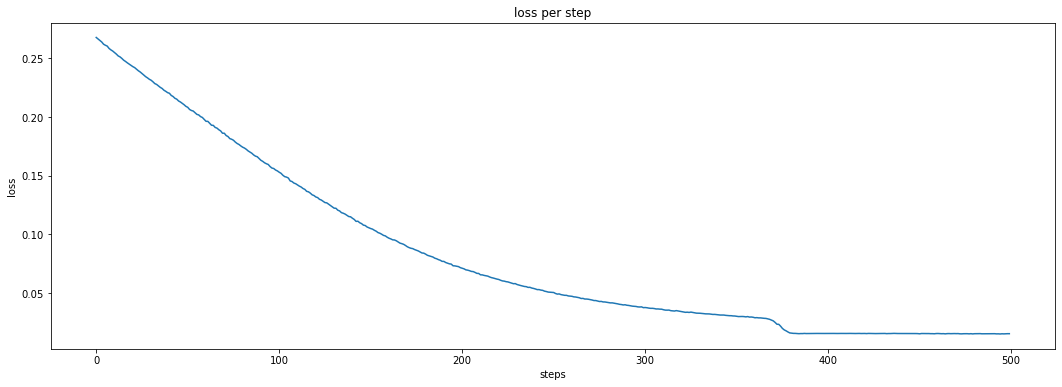

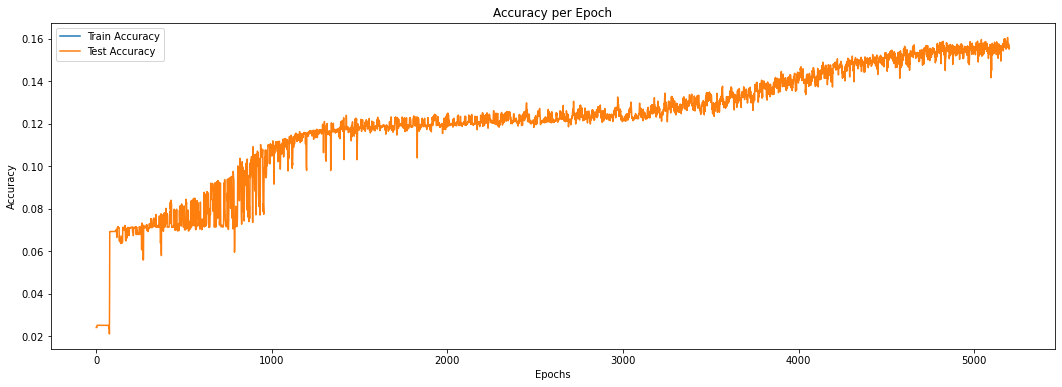

In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

class SenseNet(nn.Module):
    def __init__(self):
        super(SenseNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3, padding=1)
        self.flat1 = nn.Flatten()
        self.fc1 = nn.Linear(8 * 9, 16)
        self.fc2 = nn.Linear(16, 1)
        self.fc3 = nn.Linear(1, 16)
        self.fc4 = nn.Linear(16, 8 * 8)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.flat1(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))

        return x

filename = 'board_senses.csv'

def read_and_process_csv(file_name):
    sense_board = []
    sense_position = []

    with open(file_name, 'r', newline='') as csvfile:
        senses_reader = csv.reader(csvfile)

        for row in senses_reader:
            sense_board_row = np.array(row[:66] + [0] * 6, dtype=float).reshape((8, 9)).tolist()
            sense_board.append(sense_board_row)
            position = int(row[-1])
            sense_position.append(position)

    return sense_board, sense_position

sense_board_data, sense_position_data = read_and_process_csv(filename)

# trainings- and testsets
sense_board_train, sense_board_test, sense_position_train, sense_position_test = train_test_split(
    sense_board_data, sense_position_data, test_size=0.2, random_state=42)

sense_position_train = torch.tensor(sense_position_train)
sense_position_train -= 1
sense_position_one_hot_train = torch.nn.functional.one_hot(sense_position_train, num_classes=64).float()

sense_position_test = torch.tensor(sense_position_test)
sense_position_test -= 1
sense_position_one_hot_test = torch.nn.functional.one_hot(sense_position_test, num_classes=64).float()



model = SenseNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

sense_board_train_tensor = torch.tensor(sense_board_train, dtype=torch.float32).unsqueeze(1)
sense_position_one_hot_train_tensor = torch.tensor(sense_position_one_hot_train, dtype=torch.float32)

sense_board_test_tensor = torch.tensor(sense_board_test, dtype=torch.float32).unsqueeze(1)
sense_position_one_hot_test_tensor = torch.tensor(sense_position_one_hot_test, dtype=torch.float32)

epochs = 10
batch_size = 64
list_of_losses = []
accuracy_list_train = []
accuracy_list_test = []

# Training
for epoch in range(epochs):
    for i in range(0, len(sense_board_train_tensor), batch_size):
        inputs = sense_board_train_tensor[i:i + batch_size]
        targets = sense_position_one_hot_train_tensor[i:i + batch_size]

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        list_of_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            with torch.no_grad():
                test_predictions = model(sense_board_test_tensor)
                test_accuracy = torch.sum(torch.argmax(test_predictions, dim=1) == torch.argmax(sense_position_one_hot_test_tensor, dim=1)).item() / len(sense_position_test)
                accuracy_list_test.append(test_accuracy)

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}, Test Accuracy: {test_accuracy}')

# save model
torch.save(model.state_dict(), 'sense_net.pth')

# Plots
def plot_numbers(numbers):
    fig, ax = plt.subplots(figsize=(18, 6))
    ax.plot(numbers)
    ax.set_xlabel('steps')
    ax.set_ylabel('loss')
    ax.set_title('loss per step')
    plt.show()

plot_numbers(list_of_losses[:500])
plot_numbers(accuracy_list_test)


In [99]:
print("sense_board:")
for entry in sense_board_data:
    entry_tensor = torch.tensor(entry, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    output = model(entry_tensor)
    print(entry_tensor)
    print(output)
    # break

sense_board:
tensor([[[[ 4.,  2.,  3.,  5.,  6.,  3.,  2.,  4.],
          [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [12., 12., 12., 12., 12., 12., 12., 12.],
          [ 9., 11., 10.,  8.,  7., 10., 11.,  9.]]]])
tensor([[6.2544e-07, 7.7326e-07, 1.6032e-06, 6.6549e-07, 8.2515e-07, 1.0173e-06,
         1.9416e-06, 8.1342e-07, 2.7005e-02, 3.5559e-02, 2.5603e-02, 4.5728e-02,
         2.3663e-02, 3.0061e-02, 1.1789e-06, 2.0693e-06, 1.1651e-02, 6.5209e-03,
         1.0722e-02, 1.0130e-02, 5.6544e-03, 1.3221e-02, 8.6392e-07, 9.7930e-07,
         1.9350e-02, 1.9544e-02, 1.2820e-02, 8.8999e-03, 1.0086e-02, 1.9587e-02,
         5.2007e-07, 8.2947e-07, 2.6278e-02, 2.0388e-02, 9.1035e-03, 1.0056e-02,
         1.2295e-02, 2.3168e-02, 8.4495e-07, 7.1638e-07, 1.7549e-02, 7.7395e-03,
 